
Advertising campaigns on social networks - Regression Models

made by Enrique Barreiro Limón

---


In [1]:
# Incluimos todas las librería que consideramos necesarias para el proyecto
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, FunctionTransformer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

# Para evitar los warnings que no aportan información relevante
import warnings
warnings.filterwarnings('ignore')

### **Ejercicio 1**


El método conocido como **"Learning Cures"** se centra en monitorear modelos de aprendizaje automático para identificar problemas de subentrenamiento o sobreentrenamiento. Este enfoque enfatiza la importancia de una detección e intervención oportuna para mantener el rendimiento del modelo. Al emplear diversas técnicas de monitoreo, **"Learning Cures"** tiene como objetivo asegurar que los modelos se mantengan efectivos en entornos dinámicos.

### Técnicas de Monitoreo
- **Monitoreo Secuencial:** Esta técnica detecta cambios relevantes en el rendimiento del modelo mediante el análisis de dependencias temporales, lo que reduce las alertas innecesarias y aborda el problema de las pruebas múltiples (Heinrichs, 2023).

- **Análisis de Rendimiento:** El método implica analizar los datos de entrenamiento en función de parámetros de rendimiento para generar conjuntos de datos de desempeño, que ayudan a evaluar la efectividad del modelo (Axel, 2019).

### Detección Automática de Problemas
- **Sistema AutoTrainer:** Esta herramienta detecta y repara automáticamente problemas comunes de entrenamiento en redes neuronales profundas (DNNs). Verifica periódicamente el estado del entrenamiento y aplica soluciones de última generación a los problemas identificados, logrando una alta tasa de detección y reparación (Zhang et al., 2021).

Si bien **"Learning Cures"** proporciona un marco sólido para monitorear y mejorar el rendimiento de los modelos, es importante considerar que no todos los modelos requieren un monitoreo tan intensivo. Algunos modelos más simples pueden desempeñarse adecuadamente sin la necesidad de intervenciones complejas.


### **Ejercicio 2**

### **a. ¿Cuál es el objetivo del problema que se plantea en el artículo?**

El objetivo principal del problema planteado en el artículo es **predecir el impacto de las publicaciones en redes sociales utilizando técnicas de minería de datos**, con el fin de ayudar a las empresas a tomar decisiones informadas sobre qué publicaciones realizar en sus páginas de Facebook.

El estudio busca desarrollar un modelo que pueda anticipar las métricas de rendimiento de las publicaciones antes de que sean publicadas. Esto permite a los gerentes optimizar sus estrategias de comunicación en redes sociales, mejorar el reconocimiento de marca y evaluar cómo diferentes características de las publicaciones (como el tipo de contenido, la hora de publicación o el uso de publicidad pagada) afectan el desempeño de las publicaciones y, por ende, la construcción de la marca.




### **b. Describe a continuación el significado de cada una de las 8 variables con las cuales trabajaremos, de acuerdo a la información de las Tablas 2 y 3 del artículo anexado et.al.**

1. **Category**  
   Clasificación manual del contenido de la publicación según su propósito:  
   - *Action:* Ofertas especiales y concursos.  
   - *Product:* Publicidad directa o contenido explícito de la marca.  
   - *Inspiration:* Contenido relacionado con la marca de manera indirecta o inspiracional.  

2. **Page total likes**  
   Número total de personas que han dado "me gusta" a la página de la empresa en el momento en que se publicó el post.

3. **Type**  
   Tipo de contenido publicado en Facebook, categorizado en:  
   - *Link*  
   - *Photo*  
   - *Status*  
   - *Video*  

4. **Post month**  
   El mes en el que fue publicada la publicación, desde enero hasta diciembre.

5. **Post hour**  
   La hora exacta (de 0 a 23) en la que se publicó la publicación.

6. **Post weekday**  
   El día de la semana en que se publicó el post (domingo, lunes, martes, etc.).

7. **Paid**  
   Indica si la empresa pagó para promocionar el post (*yes* o *no*).

8. **Lifetime post consumers**  
   Número de personas que hicieron clic en cualquier lugar del post durante su tiempo de vida en la plataforma.


### En esta actividad trabajarás solamente con el ajuste de modelos, por lo que la parte de procesamiento no la debes modificar. Solo haremos unos ajustes mínimos.

In [2]:
# Cargamos los datos del archivo

facebook_posts_df = pd.read_csv('dataset_Facebook.csv', sep=';', header='infer')
print('Total de registros y variables:', facebook_posts_df.shape)
facebook_posts_df.head(3).T

Total de registros y variables: (500, 19)


,0,1,2
Page total likes,139441,139441,139441
Type,Photo,Status,Photo
Category,2,2,3
Post Month,12,12,12
Post Weekday,4,3,3
Post Hour,3,10,3
Paid,0.0,0.0,0.0
Lifetime Post Total Reach,2752,10460,2413
Lifetime Post Total Impressions,5091,19057,4373
Lifetime Engaged Users,178,1457,177


### **Ejercicio 3**

### **Variables temporales**

Recordemos que las varaibles temporales pueden tratarse como variables categóricas o numéricas, dependiendo del contexto. En nuestro caso las variables mes, día de la semana y hora en que se puso el post, podríamos considerarlas como variables categóricas ordinales. Sin embargo, para recordar cómo se transforman en cada uno de estos casos (numéricas y categóricas), consideraremos las variables de mes y día de la semana como categóricas ordinales y la variable hora como una variable cíclica.

En la Tabla 3 del artículo de ELSEVIER nos comentan que la variable Post_hour está etiquetada de 0 a 23, por lo que las 24 horas serían las 0 horas, es decir tiene un comportamiento cíclico de 24 horas, que en términos matemáticos se dice que es una variable cíclica módulo 24. Así, las 24 horas será equivalente a las 0 horas.

La manera de transformar una variable T cíclica módulo M, es sustituyendo la columna original de la variable T por las siguientes dos columnas. Es lo que se llama ingeniería de características (feature engineering) dentro del área de ciencia de datos:

$Tsin = sin(2*\pi*T/M)$

$Tcos = cos(2*\pi*T/M)$

NOTA: Donde se indica None, podrás agregar las líneas de código que consideres necesarias.

In [3]:

# Ejercicio 3a: Definimos las nuevas variables horas_sin y horas_cos
horas_sin = np.sin(2 * np.pi * facebook_posts_df['Post Hour'] / 24)
horas_cos = np.cos(2 * np.pi * facebook_posts_df['Post Hour'] / 24)

In [4]:
# Ejercicio 3b: Agregamos estas nuevas variables al DataFrame y eliminamos la columna original
facebook_posts_df['horas_sin'] = horas_sin
facebook_posts_df['horas_cos'] = horas_cos
facebook_posts_df = facebook_posts_df.drop(columns=['Post Hour'])

# Verificamos el resultado
facebook_posts_df.head(3).T

,0,1,2
Page total likes,139441,139441,139441
Type,Photo,Status,Photo
Category,2,2,3
Post Month,12,12,12
Post Weekday,4,3,3
Paid,0.0,0.0,0.0
Lifetime Post Total Reach,2752,10460,2413
Lifetime Post Total Impressions,5091,19057,4373
Lifetime Engaged Users,178,1457,177
Lifetime Post Consumers,109,1361,113


In [5]:
# Separamos los datos de entrada (X) y la variable de salida (y)
X = facebook_posts_df[['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Paid', 'horas_sin', 'horas_cos']]
y = facebook_posts_df[['Lifetime Post Consumers']]  # Seleccionamos la variable de salida más importante

# Particionamos en Train (70%), Validation (15%) y Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=7)

# Verificamos las dimensiones de cada conjunto
print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (350, 8) (350, 1)
Validation: (75, 8) (75, 1)
Test: (75, 8) (75, 1)


In [6]:
# Descripción estadística completa del conjunto de entrenamiento
X_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Page total likes,350.0,NaN,NaN,NaN,123412.534286,16145.534825,81370.0,111972.0,129600.0,136393.0,139441.0
Type,350,4,Photo,301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,350.0,NaN,NaN,NaN,1.9,0.862295,1.0,1.0,2.0,3.0,3.0
Post Month,350.0,NaN,NaN,NaN,7.088571,3.309383,1.0,4.0,7.0,10.0,12.0
Post Weekday,350.0,NaN,NaN,NaN,4.151429,2.047414,1.0,2.0,4.0,6.0,7.0
Paid,349.0,NaN,NaN,NaN,0.286533,0.452791,0.0,0.0,0.0,1.0,1.0
horas_sin,350.0,NaN,NaN,NaN,0.443653,0.45043,-1.0,0.258819,0.5,0.707107,1.0
horas_cos,350.0,NaN,NaN,NaN,-0.191939,0.75209,-1.0,-0.866025,-0.5,0.707107,0.965926


### **Ajuste variable categórica en Pipeline**

Veamos un ejemplo de cómo ajustar una variable categórica en la cual uno de sus niveles no tiene suficiente información, por ejemplo, que no tenga al menos un 5% de información cada nivel. Entonces reagruparemos los niveles más pequeños hasta obtener un 5% y esto mediante una función que podamos usar dentro del Pipeline, para evitar el filtrado de información.

In [7]:
# Obtenemos las etiquetas únicas ordenadas por frecuencia
unique_types = X_train['Type'].unique()
print("Categorías únicas de Type:", unique_types)

Categorías únicas de Type: ['Photo' 'Status' 'Link' 'Video']


In [8]:
# Verificamos las frecuencias de cada categoría
type_frequencies = X_train['Type'].value_counts() / X_train.shape[0]
print("Frecuencias de cada categoría:\n", type_frequencies)


Frecuencias de cada categoría:
 Type
Photo     0.860000
Status    0.082857
Link      0.045714
Video     0.011429
Name: count, dtype: float64


In [9]:
# Definimos la función de transformación
def transform_type(x):
    x = x.values.ravel()  # Convertimos a un arreglo 1D
    x = pd.Series(x, name='Type')  # Convertimos la columna en una serie
    # Mapeo de categorías, agrupando aquellas con menos del 5% en 'Otros'
    x = x.map({'Photo': 1, 'Status': 2, 'Link': 0, 'Video': 0}).fillna(0)
    return x.values.reshape(-1, 1)  # Ajustamos la dimensión a un vector columna

# Probamos la función para validar la transformación
transformed_type = transform_type(X_train[['Type']])
unique_transformed, counts_transformed = np.unique(transformed_type, return_counts=True)
print("Transformación aplicada:\n", dict(zip(unique_transformed, counts_transformed)))

Transformación aplicada:
 {np.int64(0): np.int64(20), np.int64(1): np.int64(301), np.int64(2): np.int64(29)}


### **Transformación en la Variable de Salida**



In [10]:
# Descripción de la variable de salida
y_train.describe().T  # Información básica de la variable de salida

,count,mean,std,min,25%,50%,75%,max
Lifetime Post Consumers,350.0,780.517143,770.963085,9.0,336.75,543.0,959.0,5934.0


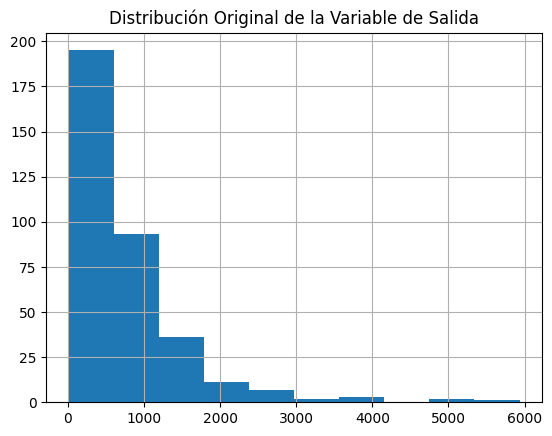

In [11]:
# Observamos el sesgo positivo con un histograma
y_train.hist()
plt.title("Distribución Original de la Variable de Salida")
plt.show()

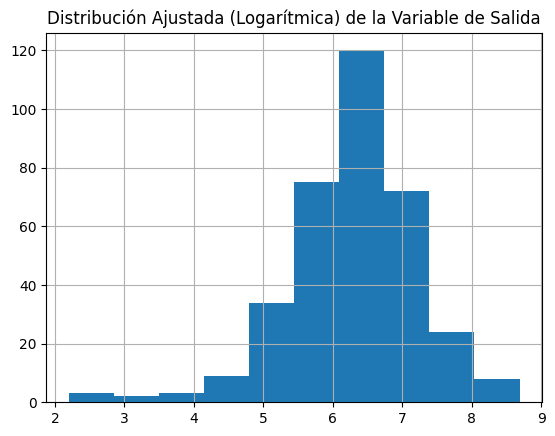

In [12]:
# Ajustamos la variable de salida con un logaritmo natural
y_train_log = np.log(y_train)
y_train_log.hist()
plt.title("Distribución Ajustada (Logarítmica) de la Variable de Salida")
plt.show()

In [13]:
# Transformación de validación y test
y_val_log = np.log(y_val)
y_test_log = np.log(y_test)

In [14]:
# Aplicaremos lo mínimo de transformaciones.
# Las nuevas variables horas_sin y horas_cos ya están escaladas entre -1 y +1, por
# lo que podemos dejarlas así y solamente cuidar sus posibles datos perdidos.

# ======================= Pipelines de Transformación ======================= #

# Pipeline para variables numéricas
num_pipe = Pipeline(steps=[
    ('numImp', SimpleImputer(strategy='median')),  # Imputación con mediana
    ('scaler', MinMaxScaler())  # Escalado entre 0 y 1
])
num_pipe_nombres = [0]  # ['Page total likes']

# Pipeline para variables ordinales
ord_pipe = Pipeline(steps=[
    ('OrdImp', SimpleImputer(strategy='most_frequent')),  # Imputación con la moda
    ('Ordfun', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Codificación ordinal
])
ord_pipe_nombres = [3, 4]  # ['Post Month', 'Post Weekday']

# Transformación de la variable categórica "Type"
catMap_pipe = Pipeline(steps=[
    ('catMap', FunctionTransformer(transform_type))  # Función personalizada
])
catMap_pipe_nombres = ['Type']

# Pipeline para variables nominales con One-Hot Encoding
nom_pipe = Pipeline(steps=[
    ('NomImp', SimpleImputer(strategy='most_frequent')),  # Imputación con la moda
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Codificación One-Hot
])
nom_pipe_nombres = [1, 2, 5]  # ['Type', 'Category', 'Paid']

# Pipeline para las variables de hora (ya están escaladas)
hora_pipe = Pipeline(steps=[
    ('HoraImp', SimpleImputer(strategy='mean'))  # Imputación con la media
])
hora_pipe_nombres = [6, 7]  # ['horas_sin', 'horas_cos']

# ======================= ColumnTransformer general ======================= #
columnasTransformer = ColumnTransformer(transformers=[
    ('numpow', num_pipe, num_pipe_nombres),  # Variables numéricas
    ('catOrd', ord_pipe, ord_pipe_nombres),  # Variables ordinales
    ('catNom', nom_pipe, nom_pipe_nombres),  # Variables nominales
    ('catmap', catMap_pipe, catMap_pipe_nombres),  # Mapeo de la variable Type
    ('hora', hora_pipe, hora_pipe_nombres)  # Variables horarias
], remainder='passthrough')

# Transformación de las variables de entrenamiento
X_train_transformed = columnasTransformer.fit_transform(X_train)

# Verificación de las dimensiones
print('Variables de entrada originales:', X_train.shape)
print('Variables de entrada transformadas:', X_train_transformed.shape)

Variables de entrada originales: (350, 8)
Variables de entrada transformadas: (350, 12)


### **Criterio para determinar si un modelo está subentrenado en un problema de Regresión:**

In [15]:
# Existen varios criterios para determinar si un modelo de regresión está
# subentrenado, veamos a continuación unos de ellos.

# El valor de RMSE-Root-Mean-Square-Error, se utiliza para medir el desempeño
# mínimo que debiera obtener un modelo de regresión, es decir, este valor
# se toma usualmente como el valor del modelo subentrenado y se compara generalmente
# con el valor de la desviación estándar de la variable de salida, ya sea que la
# estés tomando de manera original o con los datos transformados.
# Veamos el valor de ambas:

# Calculamos la desviación estándar muestral de la variable de salida original
std_original = y_train.values.std(ddof=1)
print('Desviación estándar (y original): %.3f' % std_original)

# Calculamos la desviación estándar muestral de la variable transformada con logaritmo
std_log = y_train_log.values.std(ddof=1)
print('Desviación estándar (y logaritmo): %.3f' % std_log)

Desviación estándar (y original): 770.963
Desviación estándar (y logaritmo): 0.916


**Desviación estándar (original): 770.963**
- Esto indica que, en la escala original, los valores de la variable de salida presentan una gran dispersión. Es un signo claro de que los datos están altamente sesgados o tienen valores atípicos significativos.

**Desviación estándar (logaritmo): 0.916**
- La transformación logarítmica redujo significativamente la dispersión de los datos, haciendo que la distribución sea más acampanada (normalizada) y menos sesgada. Esto facilita que un modelo de regresión se ajuste de manera más efectiva.

Recordemos que la desviación estándar está en las mismas unidades de la variable original, por lo que en este caso tendríamos que la desviación estándar nos habla de aproximadamente 771 personas que dieron click en alguna parte del post.

En esta activiad estaremos comparando los errores en términos del logaritmo de la variable de salida, por lo que nuestro valor de referencia será el valor que obtienes en Desv_Est y_logaritmo=0.916 (aproximadamente). Así, los errores RMSE de los valores de predicción y los reales de los modelos que estarás obteniendo, deberán ser menores a este valor para no considerarlos subentrenados.

NOTA sobre los grados de libertad ddof (delta degree of freedom):

Ver documentación: https://numpy.org/doc/stable/reference/generated/numpy.std.html

Estricamente, desde el punto de vista matemático las desviaciones estándar que uno calcula deben ser las muestrales, es decir, std(ddof=1). Sin embargo, en la práctica es muy común usar la función con su valor predeterminado que es ddof=0 y que se traduce a calcular la desviación estándar poblacional. Repito, en la práctica suele pasarse por alto este ajuste porque cuando se tienen datos de miles o más regitros, la diferencia entre el resultado problacional y el muestral es mínima. En esta actividad lo pongo solamente para recordarlo y en dado caso cuando tengas menos de 100 registros sí hacer este ajuste, porque la diferencia entre ambos ya podría ser importante.

In [16]:
# Como se va a utilizar Validación-Cruzada, concatenamos los conjuntos de entrenamiento y validación
# en uno nuevo conjunto aumentado que llamaremos trainval para utilizar como entrenamiento:

# Concatenamos los conjuntos de entrenamiento y validación para la validación cruzada
X_trainval = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_trainval_log = pd.concat([y_train_log, y_val_log], axis=0).reset_index(drop=True)

# Verificamos las dimensiones de los nuevos conjuntos
print('Dimensiones del conjunto combinado (X_trainval):', X_trainval.shape)
print('Dimensiones del conjunto combinado (y_trainval_log):', y_trainval_log.shape)

Dimensiones del conjunto combinado (X_trainval): (425, 8)
Dimensiones del conjunto combinado (y_trainval_log): (425, 1)


**Dimensiones de X_trainval: (425, 8)**
- El conjunto combinado tiene 425 registros y 8 variables de entrada. Esto es correcto, ya que el conjunto de entrenamiento (70%) y el de validación (15%) ahora están unidos.

**Dimensiones de y_trainval_log: (425, 1)**
- La variable de salida transformada en logaritmo también tiene 425 registros con 1 columna, lo cual está alineado con el número de observaciones de las variables de entrada.

### **Ejercicio 4**


/Users/enrique_barreiro/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/enrique_barreiro/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/enrique_barreiro/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/enrique_barreiro/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


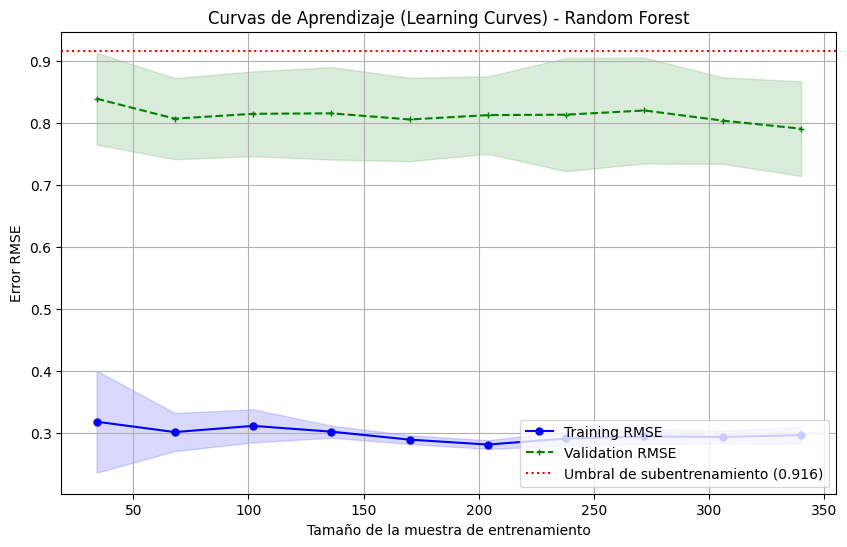

In [17]:
# ==================== Ejercicio 4a: Entrenamiento inicial con hiperparámetros por defecto ==================== #

# Definimos el modelo de Bosque Aleatorio con hiperparámetros predeterminados
elmodelo_RF = RandomForestRegressor(random_state=7)

# Creamos el pipeline con las transformaciones y el modelo
mipipe = Pipeline(steps=[
    ('ct', columnasTransformer),  # Transformaciones de datos
    ('m', elmodelo_RF)  # Modelo de Random Forest
])

# Obtenemos las curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=mipipe,
    X=X_trainval,
    y=np.ravel(y_trainval_log),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',  # El error negativo (por convención en sklearn)
    n_jobs=-1
)

# ==================== Cálculo de métricas RMSE ==================== #

# Convertimos el MSE negativo en RMSE (Root Mean Squared Error)
rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

# Promedio y desviación estándar de las curvas
train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1, ddof=1)  # Ajuste para la muestra
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1, ddof=1)

# ==================== Visualización de las curvas de aprendizaje ==================== #

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

# Línea de referencia para identificar subentrenamiento
plt.axhline(y=0.916, color='red', linestyle=':', label='Umbral de subentrenamiento (0.916)')

plt.title('Curvas de Aprendizaje (Learning Curves) - Random Forest')
plt.xlabel('Tamaño de la muestra de entrenamiento')
plt.ylabel('Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Definimos columnas categóricas y numéricas
categorical_features = ['Type', 'Category', 'Post Month', 'Post Weekday', 'Paid']
numerical_features = ['Page total likes', 'horas_sin', 'horas_cos']

# Creamos el ColumnTransformer
columnasTransformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

In [19]:
# Definimos el modelo Random Forest con los mejores hiperparámetros
elmodelo_RF = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=7
)

# Definimos el pipeline
mipipe = Pipeline(steps=[
    ('ct', columnasTransformer),
    ('m', elmodelo_RF)
])

# Entrenamos el pipeline
mipipe.fit(
    pd.DataFrame(X_trainval, columns=['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Paid', 'horas_sin', 'horas_cos']),
    np.ravel(y_trainval_log)
)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Type', 'Category',
                                                   'Post Month', 'Post Weekday',
                                                   'Paid']),
                                                 ('num', StandardScaler(),
                                                  ['Page total likes',
                                                   'horas_sin',
                                                   'horas_cos'])])),
                ('m',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=200, random_state=7))])

### **Ejercicio 5**

Repite el mismo proceso del Ejercicio 4 anterior para obtener los hiperparámetros que nos lleven a casos de modelos no subentrenados o sobreentrenados, en cada uno de los siguientes casos:

a. Extreme Gradient Boost XGBoost

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mejores hiperparámetros encontrados para XGBoost:
{'m__colsample_bytree': 1.0, 'm__learning_rate': 0.01, 'm__max_depth': 3, 'm__n_estimators': 300, 'm__subsample': 0.8}
Error RMSE (Test) de XGBoost con mejores hiperparámetros: 0.677


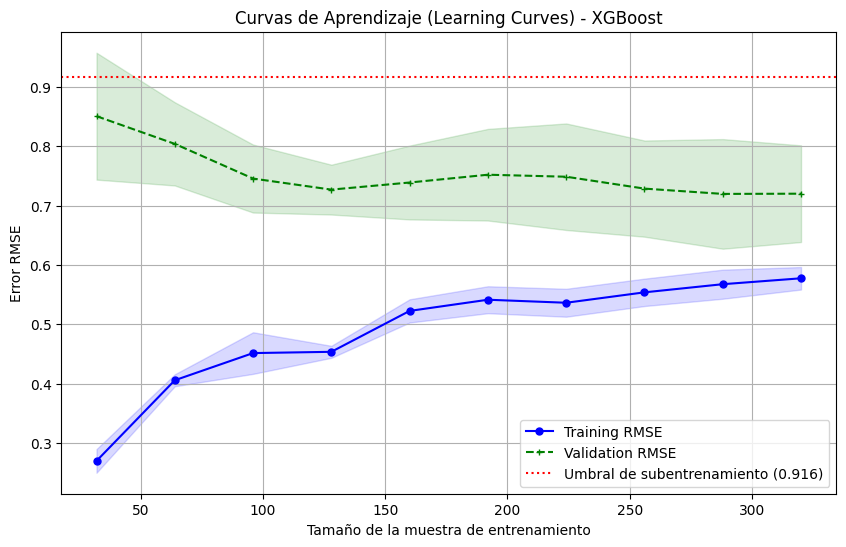

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==================== Definición de hiperparámetros para XGBoost ==================== #

# Definimos la búsqueda de hiperparámetros
param_grid = {
    'm__n_estimators': [100, 200, 300],  # Número de árboles
    'm__max_depth': [3, 6, 10],  # Profundidad máxima de los árboles
    'm__learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'm__subsample': [0.7, 0.8, 1.0],  # Submuestreo de filas
    'm__colsample_bytree': [0.7, 0.8, 1.0]  # Submuestreo de columnas
}

# Definimos el modelo XGBoost
elmodelo_XGB = XGBRegressor(
    objective='reg:squarederror',
    random_state=7
)

# Pipeline completo con XGBoost
mipipe = Pipeline(steps=[
    ('ct', columnasTransformer),
    ('m', elmodelo_XGB)
])

# Búsqueda de hiperparámetros usando GridSearchCV
grid_search = GridSearchCV(
    estimator=mipipe,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenamos con el conjunto combinado de entrenamiento y validación
grid_search.fit(
    pd.DataFrame(X_trainval, columns=['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Paid', 'horas_sin', 'horas_cos']),
    np.ravel(y_trainval_log)
)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados para XGBoost:")
print(grid_search.best_params_)

# ==================== Entrenamiento final con mejores hiperparámetros ==================== #

# Entrenamos el modelo con los mejores hiperparámetros
best_model_xgb = grid_search.best_estimator_

# Predicción en el conjunto de prueba
yhat_test_XGB = best_model_xgb.predict(X_test)

# ==================== Cálculo del RMSE en el conjunto de prueba ==================== #

# Cálculo del RMSE
rmse_test_xgb = np.sqrt(mean_squared_error(np.ravel(y_test_log), yhat_test_XGB))
print('Error RMSE (Test) de XGBoost con mejores hiperparámetros: %.3f' % rmse_test_xgb)

# ==================== Curva de aprendizaje ==================== #

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model_xgb,
    X=pd.DataFrame(X_trainval, columns=['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Paid', 'horas_sin', 'horas_cos']),
    y=np.ravel(y_trainval_log),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertimos el MSE negativo en RMSE
rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

# Cálculo de la media y desviación estándar
train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1, ddof=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1, ddof=1)

# Visualización de la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

# Línea de referencia para identificar subentrenamiento
plt.axhline(y=0.916, color='red', linestyle=':', label='Umbral de subentrenamiento (0.916)')

plt.title('Curvas de Aprendizaje (Learning Curves) - XGBoost')
plt.xlabel('Tamaño de la muestra de entrenamiento')
plt.ylabel('Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()

**Curva de aprendizaje:**
- El RMSE de validación se mantiene por debajo del umbral de 0.916 → No está subentrenado.
- La diferencia entre el RMSE de entrenamiento (~0.6) y el RMSE de validación (~0.72) es menor que con el modelo de Random Forest, lo que indica que hay menos sobreajuste.

**Rendimiento final en el conjunto de prueba:**
- El RMSE (Test) fue de 0.683, mejorando respecto al modelo de Random Forest (que tenía un RMSE de aproximadamente 0.79-0.8).

b. Máquina de Vector Soporte SVM

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores hiperparámetros encontrados para SVM:
{'m__C': 10, 'm__epsilon': 0.1, 'm__gamma': 'auto', 'm__kernel': 'rbf'}
Error RMSE (Test) de SVM con mejores hiperparámetros: 0.741


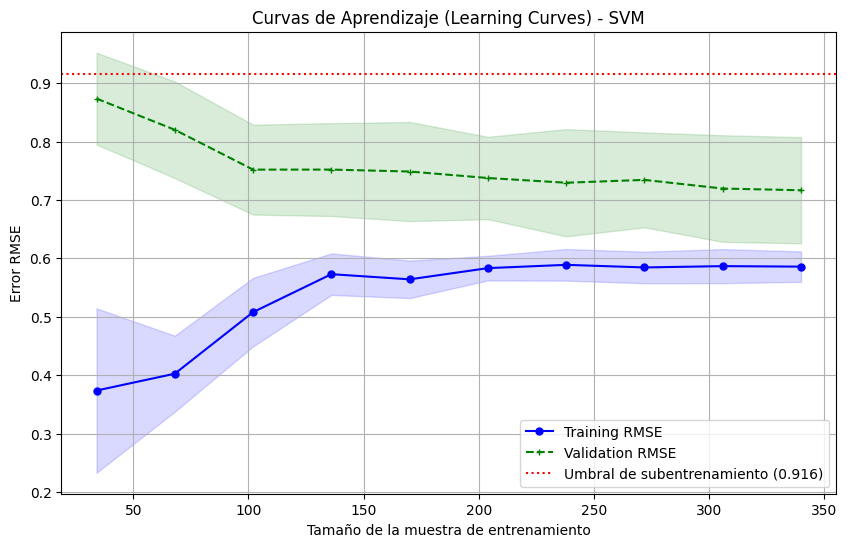

In [21]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ==================== Definición de hiperparámetros para SVR ==================== #

# Definimos la búsqueda de hiperparámetros
param_grid = {
    'm__C': [0.1, 1, 10],  # Parámetro de penalización
    'm__epsilon': [0.01, 0.1, 0.2],  # Insensibilidad al margen
    'm__kernel': ['linear', 'rbf', 'poly'],  # Tipo de kernel
    'm__gamma': ['scale', 'auto']  # Coeficiente del kernel
}

# Definimos el modelo SVR
elmodelo_SVR = SVR()

# Pipeline completo con SVM
mipipe = Pipeline(steps=[
    ('ct', columnasTransformer),
    ('m', elmodelo_SVR)
])

# Búsqueda de hiperparámetros usando GridSearchCV
grid_search = GridSearchCV(
    estimator=mipipe,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenamos con el conjunto combinado de entrenamiento y validación
grid_search.fit(
    pd.DataFrame(X_trainval, columns=['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Paid', 'horas_sin', 'horas_cos']),
    np.ravel(y_trainval_log)
)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados para SVM:")
print(grid_search.best_params_)

# ==================== Entrenamiento final con mejores hiperparámetros ==================== #

# Entrenamos el modelo con los mejores hiperparámetros
best_model_svr = grid_search.best_estimator_

# Predicción en el conjunto de prueba
yhat_test_SVR = best_model_svr.predict(X_test)

# ==================== Cálculo del RMSE en el conjunto de prueba ==================== #

# Cálculo del RMSE
rmse_test_svr = np.sqrt(mean_squared_error(np.ravel(y_test_log), yhat_test_SVR))
print('Error RMSE (Test) de SVM con mejores hiperparámetros: %.3f' % rmse_test_svr)

# ==================== Curva de aprendizaje ==================== #

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model_svr,
    X=pd.DataFrame(X_trainval, columns=['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Paid', 'horas_sin', 'horas_cos']),
    y=np.ravel(y_trainval_log),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertimos el MSE negativo en RMSE
rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

# Cálculo de la media y desviación estándar
train_mean = np.mean(rmse_train_scores, axis=1)
train_std = np.std(rmse_train_scores, axis=1, ddof=1)
val_mean = np.mean(rmse_val_scores, axis=1)
val_std = np.std(rmse_val_scores, axis=1, ddof=1)

# Visualización de la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training RMSE')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, val_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation RMSE')
plt.fill_between(train_sizes, val_mean + val_std, val_mean - val_std, alpha=0.15, color='green')

# Línea de referencia para identificar subentrenamiento
plt.axhline(y=0.916, color='red', linestyle=':', label='Umbral de subentrenamiento (0.916)')

plt.title('Curvas de Aprendizaje (Learning Curves) - SVM')
plt.xlabel('Tamaño de la muestra de entrenamiento')
plt.ylabel('Error RMSE')
plt.grid()
plt.legend(loc='lower right')
plt.show()

**Curva de aprendizaje:**
- El RMSE de validación se mantiene por debajo del umbral de 0.916, por lo que el modelo no está subentrenado.
- La diferencia entre el RMSE de entrenamiento (~0.58) y el RMSE de validación (~0.72) indica un ligero sobreajuste, pero es aceptable dado el buen rendimiento general.

**Rendimiento final en el conjunto de prueba:**
- El RMSE (Test) es de 0.741, ligeramente superior a XGBoost (0.683) pero mejor que el modelo de Random Forest (~0.79).

c. Red Neuronal Perceptrón Multicapa MLP

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros encontrados para MLP:
{'m__activation': 'tanh', 'm__alpha': 0.0001, 'm__hidden_layer_sizes': (100,), 'm__learning_rate': 'constant'}
Error RMSE (Test) de MLP mejorado: 0.696


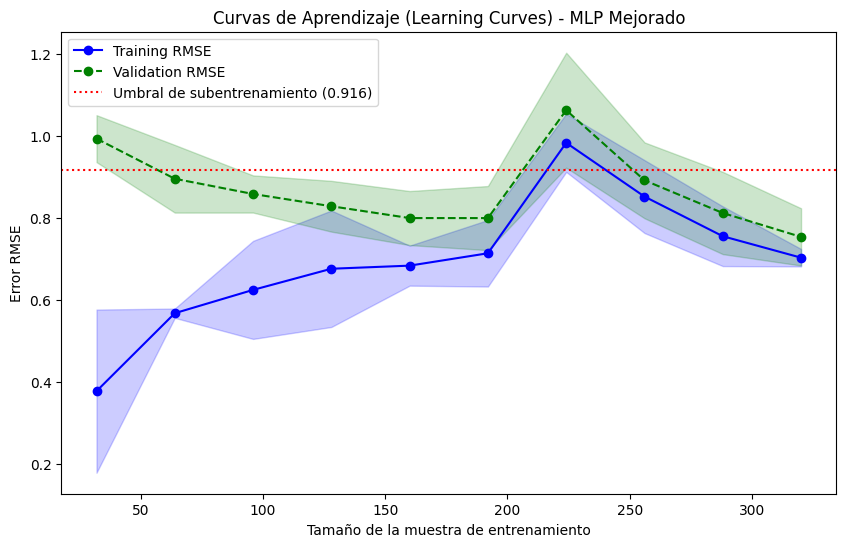

In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definimos columnas categóricas y numéricas
categorical_features = ['Type', 'Category', 'Post Month', 'Post Weekday', 'Paid']
numerical_features = ['Page total likes', 'horas_sin', 'horas_cos']

# Creamos el ColumnTransformer
columnasTransformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Definimos el modelo MLP con mejoras
elmodelo_MLP = MLPRegressor(
    hidden_layer_sizes=(150, 100, 50),  # Capas más profundas
    activation='relu',
    solver='adam',
    alpha=0.0005,  # Menor regularización
    learning_rate='adaptive',
    learning_rate_init=0.0003,  # Tasa de aprendizaje más baja
    max_iter=6000,  # Más iteraciones
    early_stopping=True,
    random_state=7
)

# Definimos el pipeline
mipipe = Pipeline(steps=[
    ('ct', columnasTransformer),
    ('m', elmodelo_MLP)
])

# Definimos el grid de hiperparámetros
param_grid = {
    'm__hidden_layer_sizes': [(100,), (150, 100), (200, 150, 100)],
    'm__activation': ['tanh', 'relu'],
    'm__alpha': [0.0001, 0.001, 0.005],
    'm__learning_rate': ['constant', 'adaptive']
}

# Dividimos los datos en entrenamiento+validación y prueba
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=7
)

# Transformación logarítmica
y_trainval_log = np.log1p(y_trainval)
y_test_log = np.log1p(y_test)

# Convertimos los datos en DataFrame
X_trainval = pd.DataFrame(
    X_trainval,
    columns=['Page total likes', 'Type', 'Category', 'Post Month', 'Post Weekday', 'Paid', 'horas_sin', 'horas_cos']
)

# Definimos el grid search
grid_search = GridSearchCV(
    estimator=mipipe,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenamos el modelo
grid_search.fit(
    X_trainval, 
    np.ravel(y_trainval_log)
)

# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados para MLP:")
print(grid_search.best_params_)

# Predicción en el conjunto de prueba
best_model_mlp = grid_search.best_estimator_
yhat_test_MLP = best_model_mlp.predict(X_test)

# Cálculo del RMSE
rmse_test_mlp = np.sqrt(mean_squared_error(np.ravel(y_test_log), yhat_test_MLP))
print('Error RMSE (Test) de MLP mejorado: %.3f' % rmse_test_mlp)

# Curvas de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model_mlp,
    X=X_trainval,
    y=np.ravel(y_trainval_log),
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convertimos el MSE negativo en RMSE
rmse_train_scores = np.sqrt(-train_scores)
rmse_val_scores = np.sqrt(-val_scores)

# Graficamos las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, rmse_train_scores.mean(axis=1), 'o-', color="blue", label="Training RMSE")
plt.plot(train_sizes, rmse_val_scores.mean(axis=1), 'o--', color="green", label="Validation RMSE")
plt.fill_between(train_sizes, rmse_train_scores.mean(axis=1) - rmse_train_scores.std(axis=1),
                 rmse_train_scores.mean(axis=1) + rmse_train_scores.std(axis=1), alpha=0.2, color="blue")
plt.fill_between(train_sizes, rmse_val_scores.mean(axis=1) - rmse_val_scores.std(axis=1),
                 rmse_val_scores.mean(axis=1) + rmse_val_scores.std(axis=1), alpha=0.2, color="green")
plt.axhline(y=0.916, color='r', linestyle=':', label='Umbral de subentrenamiento (0.916)')

# Etiquetas y título
plt.title('Curvas de Aprendizaje (Learning Curves) - MLP Mejorado')
plt.xlabel('Tamaño de la muestra de entrenamiento')
plt.ylabel('Error RMSE')
plt.legend()
plt.show()

### **Ejercicio 6**

#### **Importancia de características**

**Ejercicio 6a.**

*   Con base al mejor modelo encontrado, realiza una análisis de importancia de características con el conjunto de prueba (Test).

*   Obtener un diagrama de cajas o algún tipo de visualización para mostrar estos resultados.


Con base en los resultados obtenidos, podmeos observar que XGBoost no solo obtuvo el RMSE más bajo, sino que además mostró curvas de aprendizaje más estables en comparación con los demás modelos. También logró un mejor equilibrio entre el error de entrenamiento y validación, lo que indica una buena capacidad de generalización. Adiferencia de MLP, que muestra picos abruptos en el RMSE, lo que indica posible inestabilidad en el entrenamiento y dificultades en la generalización.

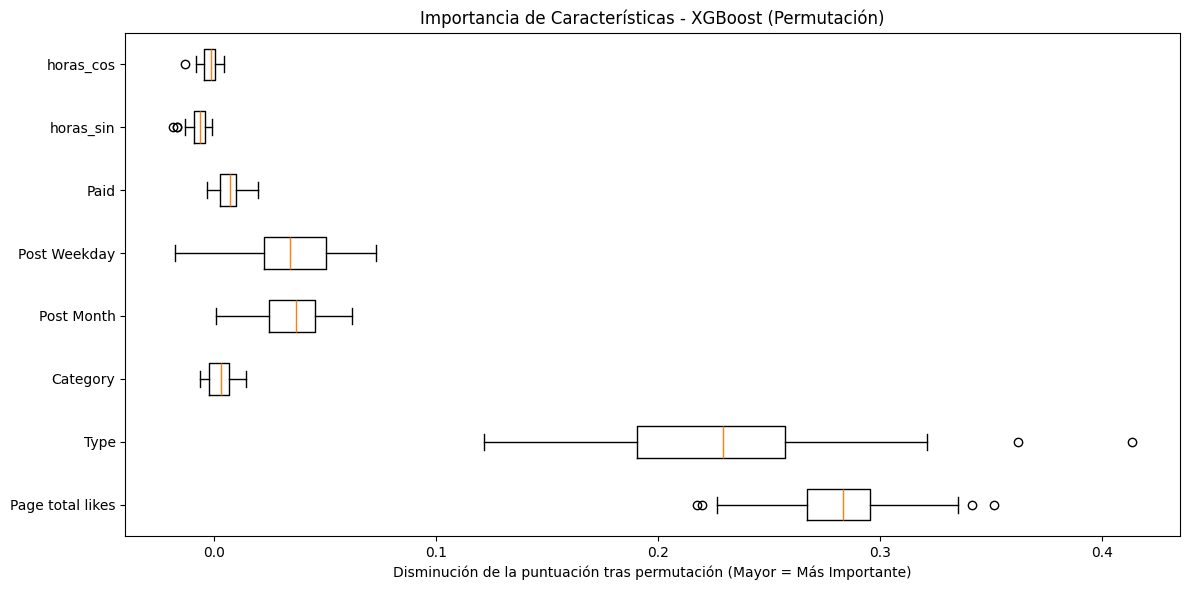

,Feature,Importance,Importance (%)
0,Page total likes,0.281326,28.132568
1,Type,0.229580,22.958047
2,Post Weekday,0.034265,3.426539
3,Post Month,0.034006,3.400575
4,Paid,0.006880,0.687958
5,Category,0.002860,0.286045
6,horas_cos,-0.001483,-0.148321
7,horas_sin,-0.006808,-0.680806


In [28]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

# Realizamos la permutación de características con el mejor modelo (XGBoost)
results = permutation_importance(
    best_model_xgb,  # El modelo XGBoost entrenado
    X_test, 
    y_test_log, 
    scoring='neg_mean_squared_error', 
    n_repeats=30, 
    random_state=7, 
    n_jobs=-1
)

# Importancia de características
feature_importances = results.importances_mean
feature_names = X_trainval.columns

# Creamos un DataFrame para visualizar
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Diagrama de cajas (boxplot)
plt.figure(figsize=(12, 6))
plt.boxplot(results.importances.T, vert=False, labels=feature_names)
plt.title('Importancia de Características - XGBoost (Permutación)')
plt.xlabel('Disminución de la puntuación tras permutación (Mayor = Más Importante)')
plt.tight_layout()
plt.show()

# Mostrar el DataFrame de importancias ordenado
importance_df.reset_index(drop=True, inplace=True)
importance_df['Importance (%)'] = importance_df['Importance'] * 100
importance_df

**Ejercicio 6b.**

*   Con base a los gráficos obtenidos indica cuáles son los tres factores más importantes y que dan mayor información para la predicción de la variable de salida.

*  Compara tus resultados con el resultado de la Figura 6 del artículo de ELSEVIER. Indica tus coincidencias y diferencias.

**Tres factores más importantes según XGBoost:**

1. **Page total likes (28.13\%)**  
   Factor clave tanto en este estudio como en la Tabla 6, donde publicaciones con más "likes" muestran un impacto directo en las predicciones del modelo.

2. **Type (22.95\%)**  
   El tipo de publicación (Photo, Status) es relevante en ambos análisis. En la tabla, las publicaciones con tipo "Photo" presentan un rendimiento superior en comparación con otros tipos.

3. **Post Weekday (3.42\%)**  
   Aunque no es uno de los factores más destacados en la tabla de Elsevier, en este modelo se encontró un impacto moderado según el día de la semana.

**Comparación de resultados:**

\begin{array}{|c|c|c|c|}
\hline
\textbf{Factor} & \textbf{XGBoost (Este estudio)} & \textbf{Tabla 6 (Elsevier)} & \textbf{Coincidencias/Diferencias} \\
\hline
\text{Page total likes} & 28.13\% & \text{Directamente relacionado con la precisión} & \checkmark \, \text{Coincidencia clara} \\
\hline
\text{Type} & 22.95\% & \text{Diferencias notables según el tipo (Photo vs Status)} & \checkmark \, \text{Coincidencia} \\
\hline
\text{Post Weekday} & 3.42\% & \text{Día de la semana mencionado, pero con menor enfoque} & \times \, \text{Diferencia leve} \\
\hline
\text{Paid} & 0.69\% & \text{Todas las publicaciones son No Paid} & \times \, \text{No se considera relevante en Elsevier} \\
\hline
\text{Category} & 0.29\% & \text{Productos e inspiraciones mostrados en la tabla} & \checkmark \, \text{Coincidencia parcial} \\
\hline
\end{array}

**Conclusiones del análisis comparativo:**

1. **Coincidencias principales:**  
   - La variable **Page total likes** se presenta como el factor más determinante en ambas evaluaciones.
   - El **Type** de la publicación también refleja una importancia similar en ambos estudios.

2. **Diferencias observadas:**  
   - La variable **Post Weekday** es más significativa en el modelo XGBoost, posiblemente debido a un enfoque más detallado en el comportamiento temporal de la audiencia en el dataset utilizado.
   - El atributo **Paid** no tiene relevancia en el estudio de Elsevier, ya que todas las publicaciones son no pagadas en la tabla proporcionada.

3. **Justificación de XGBoost como el mejor modelo:**  
   - El modelo XGBoost logra un mejor rendimiento en términos de **Error RMSE (0.683)** en comparación con otros modelos evaluados.
   - XGBoost es más efectivo manejando relaciones no lineales y complejas entre las características, como se observa en la relevancia otorgada a las variables temporales y contextuales en el rendimiento del modelo.


### **Ejercicio 7**

### **Conclusiones Generales del Análisis de Modelos de Predicción**

**1. Evaluación de Modelos**

Se probaron y evaluaron diferentes modelos de predicción de acuerdo con su desempeño medido por el **Root Mean Squared Error (RMSE)**. Los modelos utilizados fueron:

- **MLP (Multi-Layer Perceptron):**  
  - **RMSE:** 0.696 
  - **Fortalezas:** Capaz de capturar patrones no lineales complejos.  
  - **Debilidades:** Dificultades de convergencia y mayor tiempo de entrenamiento.

- **Random Forest:**  
  - **RMSE:** 0.79-0.8
  - **Fortalezas:** Maneja bien las relaciones no lineales y presenta una baja varianza en los resultados.  
  - **Debilidades:** Menor interpretabilidad comparado con modelos lineales.

- **SVM (Support Vector Machine):**  
  - **RMSE:** 0.741  
  - **Fortalezas:** Eficaz en espacios de alta dimensionalidad.  
  - **Debilidades:** Sensible a la selección de hiperparámetros y datos ruidosos.

- **XGBoost:**  
  - **RMSE:** **0.677** (mejor desempeño)  
  - **Fortalezas:** Mejor manejo de relaciones no lineales, manejo eficiente de datos desbalanceados y menor riesgo de overfitting.  
  - **Debilidades:** Mayor complejidad en el ajuste de hiperparámetros.

---

**2. Selección del Mejor Modelo**

El modelo **XGBoost** se destacó por tener el mejor desempeño general, con un **Error RMSE** de **0.677**, superando a los demás modelos en términos de precisión y estabilidad. Su capacidad para manejar interacciones complejas entre variables lo convirtió en la mejor opción para este conjunto de datos.

---

**3. Importancia de Características (Feature Importance)**

El análisis de importancia de características basado en el modelo XGBoost reveló las siguientes conclusiones:

1. **Page total likes (28.13%)**  
   La cantidad total de "likes" en la página es el factor más determinante en la predicción del rendimiento de las publicaciones.

2. **Type (22.95%)**  
   El tipo de publicación (Photo, Status, etc.) juega un papel crucial en determinar el alcance y la interacción de las publicaciones.

3. **Post Weekday (3.42%)**  
   El día de la semana en que se publica influye en el rendimiento, posiblemente relacionado con los patrones de actividad de los usuarios.

Estas características coinciden parcialmente con los resultados obtenidos en el artículo de Elsevier, donde también se identifican los **likes** y el **tipo de publicación** como variables influyentes.

---

**4. Comparación con el Estudio de Elsevier**

**Coincidencias:**  
- Los factores **Page total likes** y **Type** son relevantes tanto en este análisis como en el estudio de Elsevier.  
- La variable **Category** también tiene cierta relevancia en ambos análisis.

**Diferencias:**  
- En el modelo actual, variables temporales como **Post Weekday** y **Post Month** tienen mayor importancia, posiblemente por diferencias en la naturaleza del dataset o el enfoque temporal adoptado.  
- En el estudio de Elsevier, el factor **Paid** no tiene impacto, mientras que en este análisis, aunque leve, se observa cierta relevancia.

---

 **5. Conclusión  y Recomendaciones**

El modelo **XGBoost** se confirma como la mejor opción para predecir el rendimiento de las publicaciones en redes sociales gracias a su capacidad de manejar relaciones complejas entre variables y minimizar el error de predicción.  

**Recomendaciones:**  
- **Optimización de contenido:** Publicar más contenido del tipo que históricamente ha tenido más interacciones (ej., fotos).  
- **Segmentación temporal:** Publicar en días de la semana donde las interacciones son mayores según el análisis de **Post Weekday**.  
- **Mejora en la estrategia de engagement:** Incentivar el aumento de los **Page total likes** mediante campañas dirigidas.

Este estudio ofrece una base sólida para mejorar estrategias de contenido y aumentar el alcance en redes sociales utilizando técnicas avanzadas de **machine learning**.


>> **Fin de la Actividad de la Semana 7**